In [1]:
from sav_extract import sav_extract
filename='iris2model.sav'
iris2model=sav_extract(filename)

Your file iris2model.sav contains an inversion of a single raster and will be returned as a numpy.record...
...with the required structure


In [2]:
from data_extract import tag_extract, kpeak_ind_extract, trimmed_rows, data_trim

wavelength  = tag_extract(iris2model,'wl') # need this one first
iris_cal    = tag_extract(iris2model,'iris_cal') # then this one to get trimmed rows from kpeak frame

kpeak_ind   = kpeak_ind_extract(wavelength) # isolate the wavelength index closest to Mg II k peak
frame       = iris_cal[kpeak_ind,...] # create a frame at this peak wavelength, where FL is most visible
trimmed_rows= trimmed_rows(frame) # cuts FOV to only include observed data, not zeros at top and bottom (returns list of top and bottom row)

del frame # it has served its purpose to get trimmed rows, now delete to save confusion pre-trim
del wavelength

iris_cal    = data_trim(iris_cal, trimmed_rows,'iris_cal')

iris_cal has successfully been trimmed to (217, 183, 32)


In [3]:
import numpy as np
import alphashape
from scipy.signal import find_peaks
import copy
frame=iris_cal[kpeak_ind]
frame_original=copy.deepcopy(frame)

Text(21, 100, 'slit row values')

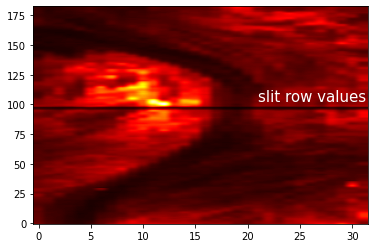

In [4]:
import matplotlib.pyplot as plt
plt.imshow(frame,aspect='auto', origin='lower',interpolation=None,cmap='hot')
plt.annotate('slit row values',(21,100),horizontalalignment='left', verticalalignment='bottom',fontsize=15,color='w')

In [5]:
### set slit rows from stats.mode
import scipy.stats as stats

slit_rows=[]
for col in range(frame.shape[1]):
    slit_rows.append(np.argmin(frame[:,col]))

slit_row=int(stats.mode(slit_rows)[0])

In [6]:
###LI slit rows to np.amax(frame) - in prep for find peaks

frame[slit_row,:]=np.amax(frame) 
frame[slit_row-1,:]=np.amax(frame)

### then do find peaks for thresh here:
frame_linear=np.reshape(frame,-1)
bin_number=int(len(frame_linear)/80)
hist,bins = np.histogram(frame_linear, bins = bin_number) # iteratively decided on 70 bins
bin_centres = 0.5*(bins[1:]+bins[:-1])

from scipy.signal import find_peaks
peaks, _ = find_peaks(-hist) # find troughs
index=peaks[0] # since bin size is so big, first trough corresponds to post-FL dip.
thresh=bin_centres[index] 
frame[frame>thresh]=0


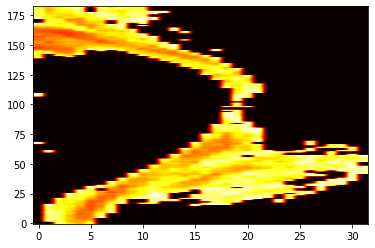

In [7]:
# plt.figure(figsize=(20,15))
plt.imshow(frame,aspect='auto', origin='lower',interpolation=None,cmap='hot')

In [8]:
from scipy.signal import medfilt
bin_mask=np.where(frame>0,1,0)
# bin_mask=np.asarray(bin_mask, dtype=np.float32) # convert bin_mask dtype to float so can L.I slit rows to nans in one step

bin_mask_no_slit=copy.deepcopy(bin_mask)
bin_mask_no_slit=medfilt(bin_mask_no_slit)

bin_mask[slit_row,:]=100
bin_mask[slit_row-1,:]=100
bin_mask=np.where(bin_mask>1,np.nan,bin_mask)
bin_mask=medfilt(bin_mask)
# for now, it seems better to actually do it in two stages as nan's need float BUT having array of floats messes up the pix assignment

Text(21, 100, 'slit row values')

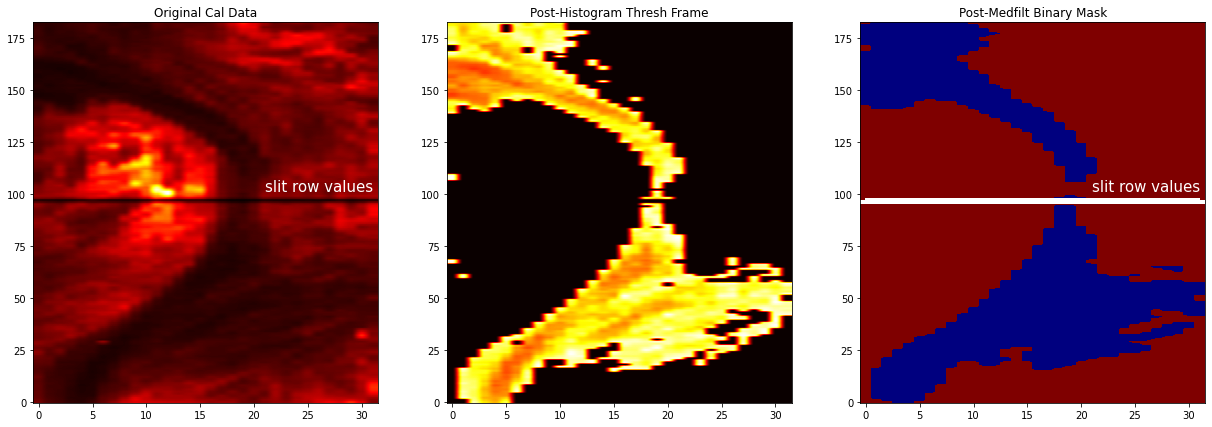

In [9]:
cmap = plt.get_cmap('jet_r', 2)
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax=ax.flat

ax[0].set(title='Original Cal Data')
ax[1].set(title='Post-Histogram Thresh Frame')
ax[2].set(title='Post-Medfilt Binary Mask')



ax[0].imshow(frame_original,aspect='auto',origin='lower',interpolation=None,cmap='hot') # original iris cal data
ax[0].annotate('slit row values',(21,100),horizontalalignment='left', verticalalignment='bottom',fontsize=15,color='w')

ax[1].imshow(frame,aspect='auto',origin='lower',interpolation=None,cmap='hot') # frame threshold using hist method

ax[2].imshow(bin_mask,aspect='auto',origin='lower',interpolation=None,cmap=cmap) # binary map after medfilter
ax[2].set(facecolor='white')
ax[2].annotate('slit row values',(21,100),horizontalalignment='left', verticalalignment='bottom',fontsize=15,color='w')



In [10]:
fl_pix=[]
qs_pix=[]
slit_pix=[]
for pix_ind, pix_val in np.ndenumerate(bin_mask):
    if pix_val==0:
        qs_pix.append(pix_ind)
    if pix_val==1:
        fl_pix.append(pix_ind)
    if np.isnan(pix_val)==True:
        slit_pix.append(pix_ind)

if len(fl_pix+qs_pix+slit_pix)==len(np.reshape(bin_mask,-1)):
    print('All binary mask pixels successfully accounted for...')

All binary mask pixels successfully accounted for...


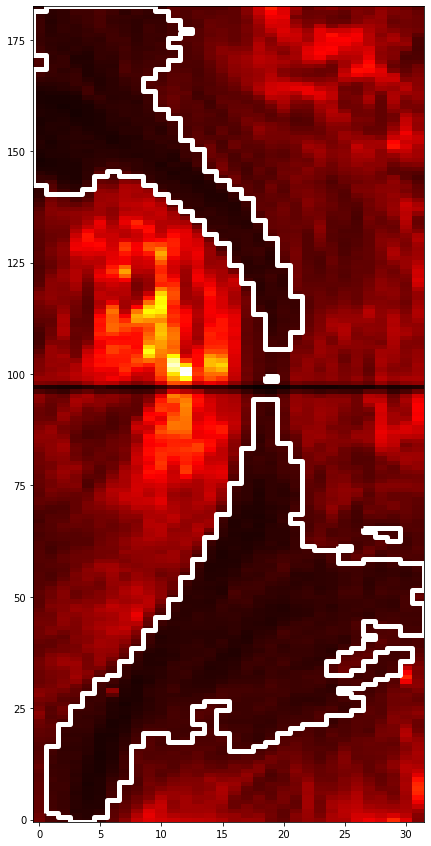

In [27]:
from matplotlib.collections import LineCollection

def get_all_boundary_edges(bool_img):
    """
    Get a list of all edges
    (where the value changes from 'True' to 'False') in the 2D image.
    Return the list as indices of the image.
    """
    ij_boundary = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            ij_boundary.append(np.array([[i, j+1],
                                         [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            ij_boundary.append(np.array([[i+1, j],
                                         [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            ij_boundary.append(np.array([[i, j],
                                         [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            ij_boundary.append(np.array([[i, j],
                                         [i, j+1]]))
    if not ij_boundary:
        return np.zeros((0, 2, 2))
    else:
        return np.array(ij_boundary)

def close_loop_boundary_edges(xy_boundary, clean=True):
    """
    Connect all edges defined by 'xy_boundary' to closed 
    boundary lines.
    If not all edges are part of one surface return a list of closed 
    boundaries is returned (one for every object).
    """

    boundary_loop_list = []
    while xy_boundary.size != 0:
        # Current loop
        xy_cl = [xy_boundary[0, 0], xy_boundary[0, 1]]  # Start with first edge
        xy_boundary = np.delete(xy_boundary, 0, axis=0)

        while xy_boundary.size != 0:
            # Get next boundary edge (edge with common node)
            ij = np.nonzero((xy_boundary == xy_cl[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                xy_cl.append(xy_cl[0])
                break

            xy_cl.append(xy_boundary[i, (j + 1) % 2, :])
            xy_boundary = np.delete(xy_boundary, i, axis=0)

        xy_cl = np.array(xy_cl)

        boundary_loop_list.append(xy_cl)

    return boundary_loop_list

def plot_world_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - 0.5
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary, **kwargs)
    ax.add_collection(cl)




plt.figure(figsize=(7,15))
plt.imshow(frame_original,aspect='auto',origin='lower',interpolation=None,cmap='hot') # original iris cal data
plt.imshow(bin_mask_no_slit, cmap='binary',origin='lower',interpolation=None,alpha=0,aspect='auto')
plot_world_outlines(bin_mask_no_slit.T, lw=5, color='w')